In [1]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
import lightgbm as lgb
from catboost import CatBoostRegressor
import scipy as sp
from scipy.fftpack import fft
from tsfresh.feature_extraction import feature_calculators


import gc
%matplotlib inline

In [2]:
%time
train_df = pd.read_csv(os.path.join("../input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [3]:
train_df.shape

(629145480, 2)

In [4]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [5]:
#Prepare empty frame
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [6]:
def add_statistics(seg_id,feat_name,X,xc,ws=""):
    X.loc[seg_id,feat_name + "_mean"+ws] = xc.mean()
    X.loc[seg_id,feat_name + "_var"+ws] = xc.var()
    X.loc[seg_id,feat_name + "_min"+ws] = xc.min()
    X.loc[seg_id,feat_name + "_max"+ws] = xc.max()
    X.loc[seg_id,feat_name + "_kurt"+ws] = xc.kurt()
    X.loc[seg_id,feat_name + "_skew"+ws] = xc.skew()
    X.loc[seg_id,feat_name + "_sum"+ws] = xc.sum()
    X.loc[seg_id,feat_name + "_mad"+ws] = xc.mad()
def add_quantiles(seg_id,feat_name,X,xc,ws=""):
    quantiles = xc.quantile([0.01,0.02,0.05,0.1,0.9,0.95,0.98,0.99])
    X.loc[seg_id,feat_name +"_1_quantile"+ws] = quantiles[0.01]
    X.loc[seg_id,feat_name +"_99_quantile"+ws] = quantiles[0.99]
    
    X.loc[seg_id,feat_name +"_2_quantile"+ws] = quantiles[0.02]
    X.loc[seg_id,feat_name +"_5_quantile"+ws] = quantiles[0.05]
    X.loc[seg_id,feat_name +"_95_quantile"+ws] = quantiles[0.95]
    X.loc[seg_id,feat_name +"_98_quantile"+ws] = quantiles[0.98]
    
    X.loc[seg_id,feat_name +"_90_quantile"+ws] = quantiles[0.9]
    X.loc[seg_id,feat_name +"_10_quantile"+ws] = quantiles[0.1]
    
from scipy import signal
def create_features(seg_id,seg, X):
    xc = seg["acoustic_data"]
    
    add_statistics(seg_id,"seg",X,xc)
    add_quantiles(seg_id,"seg",X,xc)
    
    X.loc[seg_id,"num_abs_peaks_1"] = feature_calculators.number_peaks(np.abs(xc),1)
    X.loc[seg_id,"num_peaks_1"] = feature_calculators.number_peaks(np.abs(xc),1)
    X.loc[seg_id,"num_abs_peaks_5"] = feature_calculators.number_peaks(np.abs(xc),5)
    X.loc[seg_id,"num_peaks_5"] = feature_calculators.number_peaks(np.abs(xc),5)
    X.loc[seg_id,"num_abs_peaks_30"] = feature_calculators.number_peaks(np.abs(xc),30)
    X.loc[seg_id,"num_peaks_30"] = feature_calculators.number_peaks(np.abs(xc),30)
    
    window_sizes = [10,100,500]
    for window_size in window_sizes:
        xc_rolled = xc.rolling(window_size)
        xc_rolled_var = xc_rolled.var().dropna()
        ws = str(window_size)
        
        X.loc[seg_id,"rollingVar_mean"] = xc_rolled_var.mean()
        add_quantiles(seg_id,"rollingVar",X,xc_rolled_var,ws=ws)

In [7]:
def earthquake_in_segment(seg):
    return (seg["time_to_failure"] - seg["time_to_failure"].shift()).max()>1

In [8]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg,train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]    

KeyboardInterrupt: 

In [25]:
segment_names = [file for file in os.listdir("../input") if file.startswith("seg")]
test_df = pd.DataFrame(index=segment_names, dtype=np.float64)
test_df.index = test_df.index.str[:-4]
def add_features_test(test_df,segment_names):
    signals = []
    for file in tqdm_notebook(segment_names):
        seg_id = file[:-4]
        segment = pd.read_csv(os.path.join("../input",file),dtype={'acoustic_data': np.int16})
        create_features(seg_id,segment,test_df)

add_features_test(test_df,segment_names)

In [371]:
def drop_columns(train_X,test_df,columns):
    train_X.drop(train_X.columns[train_X.columns.str.contains(columns)],axis=1,inplace=True)
    test_df.drop(test_df.columns[test_df.columns.str.contains(columns)],axis=1,inplace=True)
drop_columns(train_X,test_df,"kstat")

In [26]:
train_X.columns.values
# train_X = train_X.drop(columns=['num_peaks_50','num_peaks_500'])

array(['seg_mean', 'seg_var', 'seg_min', 'seg_max', 'seg_kurt',
       'seg_skew', 'seg_sum', 'seg_mad', 'seg_1_quantile',
       'seg_99_quantile', 'seg_2_quantile', 'seg_5_quantile',
       'seg_95_quantile', 'seg_98_quantile', 'seg_90_quantile',
       'seg_10_quantile', 'num_abs_peaks_1', 'num_peaks_1',
       'num_abs_peaks_5', 'num_peaks_5', 'num_abs_peaks_30',
       'num_peaks_30', 'rollingVar_mean', 'rollingVar_1_quantile10',
       'rollingVar_99_quantile10', 'rollingVar_2_quantile10',
       'rollingVar_5_quantile10', 'rollingVar_95_quantile10',
       'rollingVar_98_quantile10', 'rollingVar_90_quantile10',
       'rollingVar_10_quantile10', 'rollingVar_1_quantile100',
       'rollingVar_99_quantile100', 'rollingVar_2_quantile100',
       'rollingVar_5_quantile100', 'rollingVar_95_quantile100',
       'rollingVar_98_quantile100', 'rollingVar_90_quantile100',
       'rollingVar_10_quantile100', 'rollingVar_1_quantile500',
       'rollingVar_99_quantile500', 'rollingVar_2_quan

In [27]:
test_df.head()

,seg_mean,seg_var,seg_min,seg_max,seg_kurt,seg_skew,seg_sum,seg_mad,seg_1_quantile,seg_99_quantile,...,rollingVar_90_quantile100,rollingVar_10_quantile100,rollingVar_1_quantile500,rollingVar_99_quantile500,rollingVar_2_quantile500,rollingVar_5_quantile500,rollingVar_95_quantile500,rollingVar_98_quantile500,rollingVar_90_quantile500,rollingVar_10_quantile500
seg_00030f,4.491780,23.948199,-75.0,115.0,28.837568,0.327908,673767.0,3.248521,-8.0,18.0,...,34.212121,6.856970,6.563543,209.068040,6.797671,7.180265,82.244244,143.226052,36.468713,7.618100
seg_0012b5,4.171153,35.080027,-140.0,152.0,56.218955,0.295708,625673.0,3.429208,-12.0,20.0,...,40.244848,6.629899,6.633663,608.173643,6.782441,7.109655,105.670317,344.335407,49.083523,7.398842
seg_00184e,4.610260,48.260671,-193.0,248.0,162.118284,0.428688,691539.0,3.461984,-11.0,20.0,...,38.267778,6.563535,6.506112,724.232561,6.673743,6.913711,91.353792,448.264625,43.104385,7.210497
seg_003339,4.531473,16.926202,-93.0,85.0,41.241827,0.061889,679721.0,2.678503,-5.0,14.0,...,15.182222,6.046364,6.184786,204.907190,6.353711,6.561122,50.632862,118.584733,19.881619,6.765932
seg_0042cc,4.128340,33.607106,-147.0,177.0,79.539708,0.073898,619251.0,3.283856,-10.0,19.0,...,37.939394,6.397071,6.290982,621.783792,6.477130,6.758253,98.734633,233.079836,49.625150,7.017792


In [28]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [29]:
# params = {'lambda_l1': 0.009433246488160846, 
#           'bagging_freq': 5,
#           'verbose': -1,
#           'min_data_in_leaf': 11,
#           'feature_fraction': 0.6352171439545997, 
#           'objective': 'regression', 
#           'lambda_l2': 0.00555203479400822,
#           'metric': 'mae', 
#           'bagging_fraction': 0.5457256925614304,
#           'max_depth': -1, 
#           'learning_rate': 0.005548168959595165, 
#           'boosting_type': 'rf',
#           'num_leaves': 95
#          }

params = {
    'lambda_l1': 0.0024572871712140822, 
    'bagging_freq': 10,
    'verbose': -1,
    'min_data_in_leaf': 19,
    'feature_fraction': 0.5100197547698974, 
#     'objective': 'regression', 
    'objective': 'regression',
    'lambda_l2': 0.0014625950769985773, 
    'metric': 'mae',
    'bagging_fraction': 0.6251464764128412, 
    'max_depth': 10,
    'learning_rate': 0.0006717821066793879,
    'boosting_type': 'rf',
    'num_leaves': 73
}
# params = {
#     'lambda_l1': 0.00524868716055791, 
#     'bagging_freq': 18, 
#     'verbose': -1,
#     'min_data_in_leaf': 19, 
#     'feature_fraction': 0.7364883625192207, 
#     'objective': 'regression', 
#     'lambda_l2': 0.0010397644006126794, 
#     'metric': 'mae', 
#     'bagging_fraction': 0.6946170217511416,
#     'max_depth': 14,
#     'learning_rate': 0.004957775889359261, 
#     'boosting_type': 'rf',
#     'num_leaves': 71
#     }

In [30]:
features_importance = pd.DataFrame({"features":train_X.columns,
                                    "importance":np.zeros(train_X.columns.shape[0])})
predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
oof = np.zeros(train_X.shape[0])

for train_idx,val_idx in folds.split(train_X,train_y):
    X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
    X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 20000,n_jobs=-1)
    model.fit(X_train,y_train,
              eval_set=[(X_val,y_val)], 
              verbose=1000,
              early_stopping_rounds=1000)
    
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    features_importance["importance"] += model.feature_importances_
    predictions["time_to_failure"] += model.predict(test_df, num_iteration=model.best_iteration_) 

Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's l1: 2.07733
Early stopping, best iteration is:
[612]	valid_0's l1: 2.07595
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's l1: 2.07349
Early stopping, best iteration is:
[251]	valid_0's l1: 2.06479
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's l1: 2.01248
Early stopping, best iteration is:
[180]	valid_0's l1: 2.00917
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's l1: 2.02553
[2000]	valid_0's l1: 2.02538
Early stopping, best iteration is:
[1577]	valid_0's l1: 2.02483
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's l1: 2.06815
Early stopping, best iteration is:
[860]	valid_0's l1: 2.06686


In [35]:
features_importance = pd.DataFrame({"features":train_X.columns,
                                    "importance":np.zeros(train_X.columns.shape[0])})
predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
oof = np.zeros(train_X.shape[0])
params = {'loss_function':'MAE'}

for train_idx,val_idx in folds.split(train_X,train_y):
    X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
    X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
    
    model = CatBoostRegressor(iterations=8000,  eval_metric='MAE', **params)
    model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              cat_features=[], use_best_model=True, verbose=500)
    
    oof[val_idx] = model.predict(X_val)
    
    features_importance["importance"] += model.feature_importances_
    predictions["time_to_failure"] += model.predict(test_df) 

0:	learn: 5.6564080	test: 5.6175926	best: 5.6175926 (0)	total: 90ms	remaining: 11m 59s
500:	learn: 2.2237996	test: 2.2903929	best: 2.2903929 (500)	total: 21.6s	remaining: 5m 22s
1000:	learn: 1.9358226	test: 2.0523315	best: 2.0523315 (1000)	total: 44.4s	remaining: 5m 10s
1500:	learn: 1.8871296	test: 2.0362524	best: 2.0362524 (1500)	total: 1m 7s	remaining: 4m 50s
2000:	learn: 1.8470452	test: 2.0309115	best: 2.0308507 (1998)	total: 1m 31s	remaining: 4m 34s
2500:	learn: 1.8093056	test: 2.0276400	best: 2.0276400 (2500)	total: 1m 54s	remaining: 4m 11s
3000:	learn: 1.7743943	test: 2.0271855	best: 2.0268400 (2807)	total: 2m 16s	remaining: 3m 47s
3500:	learn: 1.7420246	test: 2.0287531	best: 2.0268272 (3018)	total: 2m 39s	remaining: 3m 25s
4000:	learn: 1.7145201	test: 2.0300649	best: 2.0268272 (3018)	total: 3m 23s	remaining: 3m 23s
4500:	learn: 1.6879583	test: 2.0320137	best: 2.0268272 (3018)	total: 4m 19s	remaining: 3m 21s
5000:	learn: 1.6608489	test: 2.0339483	best: 2.0268272 (3018)	total: 5m 

In [37]:
mean_absolute_error(train_y,oof)

2.0124985988325257

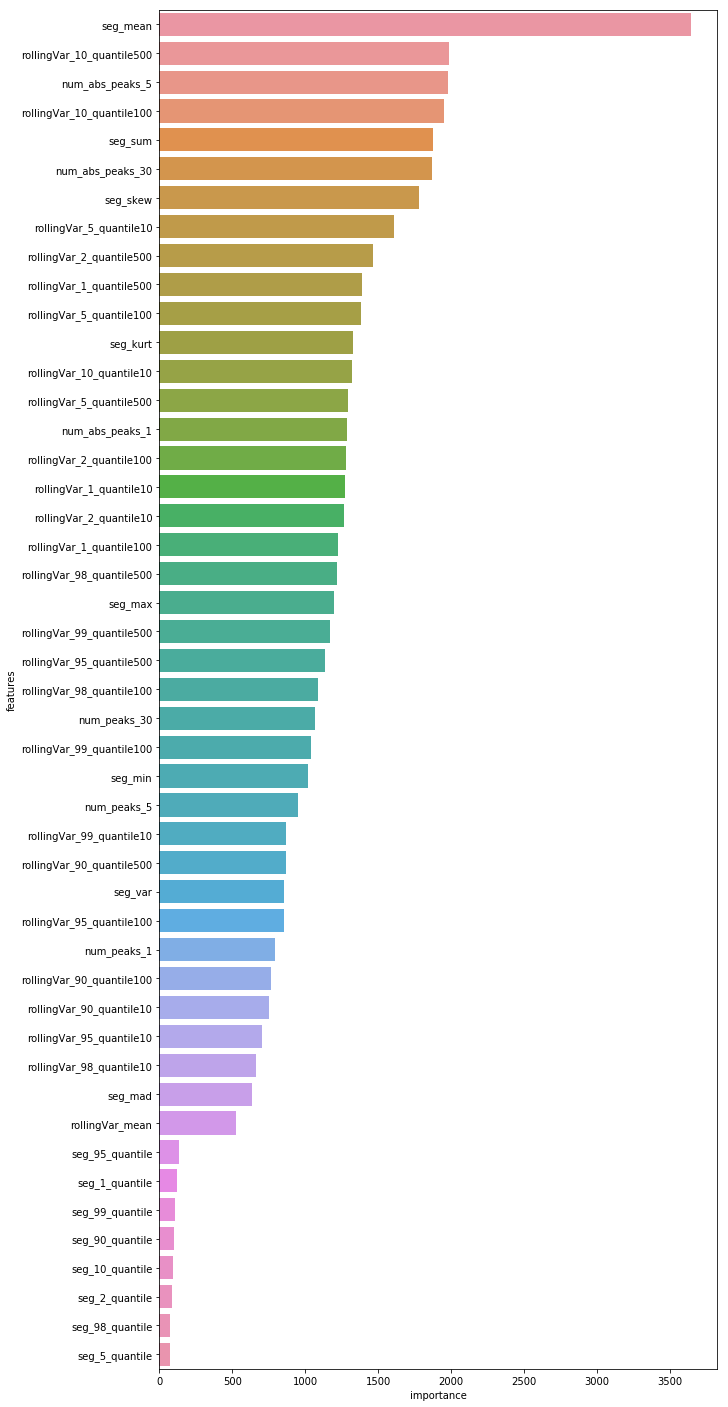

In [33]:
features_importance["importance"] = features_importance["importance"]/5
predictions["time_to_failure"] = predictions["time_to_failure"]/5

plt.figure(figsize=(10,25))
ax = sns.barplot(x="importance", y="features", data=features_importance.sort_values(by="importance",ascending=False))


In [33]:
predictions.to_csv("../submissions/submission_cat_74_scaled.csv",index=False)

In [34]:
pd.DataFrame(oof).to_csv("../oof/oof_lgb_75_earth.csv",index=False)

In [26]:
train_X.to_csv("../extracted_feat/train_73.csv",index=False)
train_y.to_csv("../extracted_feat/train_y_73.csv",index=False)

In [36]:
test_df.to_csv("../extracted_feat/test_75_earth.csv",index=False)

NameError: name 'train_y' is not defined